In [10]:
import pandas as pd
import numpy as np
from numpy.random import normal as normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib
from matplotlib import rc
from IPython.display import HTML, Image
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import plot_importance
import pickle
import json

## Define Body Parts List and Segment Lists 

In [2]:
full_body = []
right_arm = []
left_arm =[]
left_leg = []
right_leg = []
head = []

def partPosNOrien(part,source):
    source.append(part+"x")
    source.append(part+"y")
    source.append(part+"z")
    source.append("Pitch_"+part+"_orientation")
    source.append("Yaw_"+part+"_orientation")
    source.append("Roll_"+part+"_orientation")
    return source
body_parts = ["pelvis", "naval", "chest", "neck", "clavicle_left", "shoulder_left", "elbow_left", "wrist_left", "hand_left", "handtip_left", "thumb_left", "clavicle_right", "shoulder_right", "elbow_right", "wrist_right", "hand_right", "handtip_right", "thumb_right", "hip_left", "knee_left", "ankle_left", "foot_left", "hip_right", "knee_right", "ankle_right", "foot_right", "head", "nose", "eye_left", "ear_left", "eye_right", "ear_right"]

for part in body_parts:
    full_body = partPosNOrien(part,full_body)
    if part in ["neck","head", "nose", "eye_left", "ear_left", "eye_right", "ear_right"]:
        head = partPosNOrien(part,head)
    if part in ["clavicle_left", "shoulder_left", "elbow_left", "wrist_left", "hand_left", "handtip_left", "thumb_left"]:
        left_arm = partPosNOrien(part,left_arm)
    if part in ["clavicle_right", "shoulder_right", "elbow_right", "wrist_right", "hand_right", "handtip_right", "thumb_right"]:
        right_arm = partPosNOrien(part,right_arm)
    if part in ["hip_left", "knee_left", "ankle_left", "foot_left"]:
        left_leg = partPosNOrien(part,left_leg)
    if part in ["hip_right", "knee_right", "ankle_right", "foot_right"]:
        right_leg = partPosNOrien(part,right_leg)


## Calculate velocity and acceleration of joints then generate table of std, skew, and kurt of data based on predefined timeframe

In [3]:
def seizure_body_dist_data(df,full_body,dist_timeFrame):
    seizure_body_df = df[full_body]

    seizure_body_positions = []
    seizure_body_x_positions = []
    seizure_body_x_velocity_dict = {}
    seizure_body_x_acceleration_dict = {}
    seizure_body_y_positions = []
    seizure_body_y_velocity_dict = {}
    seizure_body_y_acceleration_dict = {}
    seizure_body_z_positions = []
    seizure_body_z_velocity_dict = {}
    seizure_body_z_acceleration_dict = {}
    seizure_body_orientations = []
    # Create an completely empty Dataframe without any column names, indices or data
    dfObj = pd.DataFrame()
    vel_time = np.divide(list(df["Azure_time"])[1:],1000000).tolist()
    accl_time = np.divide(list(df["Azure_time"])[2:],1000000).tolist()
    for name in full_body:
        if "orientation" not in name:
            seizure_body_positions.append(name)
            if name[-1] == 'x':
                seizure_body_x_positions.append(name)
                seizure_body_x_velocity_dict[name] = []
                seizure_body_x_acceleration_dict[name] =[]
                for i in range(0,len(list(df[name]))-1):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_x = (list(df[name])[i+1]-list(df[name])[i])
                    seizure_body_x_velocity_dict[name].append(delta_x/delta_time)
                dfObj[name+"_velocity"]=seizure_body_x_velocity_dict[name][1:]
                for i in range(0,len(list(df[name]))-2):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_vx = (seizure_body_x_velocity_dict[name][i+1]-seizure_body_x_velocity_dict[name][i])
                    seizure_body_x_acceleration_dict[name].append(delta_vx/delta_time)
                dfObj[name+"_acceleration"]=seizure_body_x_acceleration_dict[name]
            elif name[-1] == 'y':
                seizure_body_y_positions.append(name)
                seizure_body_y_velocity_dict[name] = []
                seizure_body_y_acceleration_dict[name] =[]
                for i in range(0,len(list(df[name]))-1):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_y = (list(df[name])[i+1]-list(df[name])[i])
                    seizure_body_y_velocity_dict[name].append(delta_y/delta_time)
                dfObj[name+"_velocity"]=seizure_body_y_velocity_dict[name][1:]
                for i in range(0,len(list(df[name]))-2):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_vy = (seizure_body_y_velocity_dict[name][i+1]-seizure_body_y_velocity_dict[name][i])
                    seizure_body_y_acceleration_dict[name].append(delta_vy/delta_time)
                dfObj[name+"_acceleration"]=seizure_body_y_acceleration_dict[name]
            else:
                seizure_body_z_positions.append(name)
                seizure_body_z_velocity_dict[name] = []
                seizure_body_z_acceleration_dict[name] =[]
                for i in range(0,len(list(df[name]))-1):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_z = (list(df[name])[i+1]-list(df[name])[i])
                    seizure_body_z_velocity_dict[name].append(delta_z/delta_time)
                dfObj[name+"_velocity"]=seizure_body_z_velocity_dict[name][1:]
                for i in range(0,len(list(df[name]))-2):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_z = (seizure_body_z_velocity_dict[name][i+1]-seizure_body_z_velocity_dict[name][i])
                    seizure_body_z_acceleration_dict[name].append(delta_z/delta_time)
                dfObj[name+"_acceleration"]=seizure_body_z_acceleration_dict[name]
        if "orientation" in name:
            seizure_body_orientations.append(name)
    seizure_body_x_positions_df = seizure_body_df[seizure_body_x_positions]
    seizure_body_y_positions_df = seizure_body_df[seizure_body_y_positions]
    seizure_body_z_positions_df = seizure_body_df[seizure_body_z_positions]
    # Create an completely empty Dataframe without any column names, indices or data
    dfObj2 = pd.DataFrame()

    for name in list(dfObj):
        std_list = []
        skew_list = []
        kurt_list = []
        accel_change_count_list = []
        for i in range(dist_timeFrame-1,dfObj.shape[0]):
            accel_change_count = 0
            neg_accel_count = 0
            pos_accel_count = 0
            std_list.append(dfObj[name].iloc[i-(dist_timeFrame-1):i].std())
            skew_list.append(dfObj[name].iloc[i-(dist_timeFrame-1):i].skew())
            kurt_list.append(dfObj[name].iloc[i-(dist_timeFrame-1):i].kurt())
            for j in range(i-dist_timeFrame,i):
                if name[-13] == '_' and dfObj[name].iloc[j] > 500:
                    pos_accel_count +=1
                elif name[-13] == '_' and dfObj[name].iloc[j] < -500:
                    neg_accel_count +=1
            accel_change_count = abs(pos_accel_count - neg_accel_count)
            accel_change_count_list.append(accel_change_count)
        dfObj2[name+"_std"] = std_list
        dfObj2[name+"_skew"] = skew_list
        dfObj2[name+"_kurt"] = kurt_list
        if name[-1] == 'n':
            dfObj2[name+"_accel_change_count"] = accel_change_count_list
    dfObj2['response'] = "seizure"
    return dfObj2

In [20]:
def normal_body_dist_data(df,full_body,dist_timeFrame):
    normal_body_df = df[full_body]

    normal_body_positions = []
    normal_body_x_positions = []
    normal_body_x_velocity_dict = {}
    normal_body_x_acceleration_dict = {}
    normal_body_y_positions = []
    normal_body_y_velocity_dict = {}
    normal_body_y_acceleration_dict = {}
    normal_body_z_positions = []
    normal_body_z_velocity_dict = {}
    normal_body_z_acceleration_dict = {}
    normal_body_orientations = []
    # Create an completely empty Dataframe without any column names, indices or data
    dfObj = pd.DataFrame()
    vel_time = np.divide(list(df["Azure_time"])[1:],1000000).tolist()
    accl_time = np.divide(list(df["Azure_time"])[2:],1000000).tolist()
    for name in full_body:
        if "orientation" not in name:
            normal_body_positions.append(name)
            if name[-1] == 'x':
                normal_body_x_positions.append(name)
                normal_body_x_velocity_dict[name] = []
                normal_body_x_acceleration_dict[name] =[]
                for i in range(0,len(list(df[name]))-1):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_x = (list(df[name])[i+1]-list(df[name])[i])
                    normal_body_x_velocity_dict[name].append(delta_x/delta_time)
                dfObj[name+"_velocity"]=normal_body_x_velocity_dict[name][1:]
                for i in range(0,len(list(df[name]))-2):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_vx = (normal_body_x_velocity_dict[name][i+1]-normal_body_x_velocity_dict[name][i])
                    normal_body_x_acceleration_dict[name].append(delta_vx/delta_time)
                dfObj[name+"_acceleration"]=normal_body_x_acceleration_dict[name]
            elif name[-1] == 'y':
                normal_body_y_positions.append(name)
                normal_body_y_velocity_dict[name] = []
                normal_body_y_acceleration_dict[name] =[]
                for i in range(0,len(list(df[name]))-1):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_y = (list(df[name])[i+1]-list(df[name])[i])
                    normal_body_y_velocity_dict[name].append(delta_y/delta_time)
                dfObj[name+"_velocity"]=normal_body_y_velocity_dict[name][1:]
                for i in range(0,len(list(df[name]))-2):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_vy = (normal_body_y_velocity_dict[name][i+1]-normal_body_y_velocity_dict[name][i])
                    normal_body_y_acceleration_dict[name].append(delta_vy/delta_time)
                dfObj[name+"_acceleration"]=normal_body_y_acceleration_dict[name]
            else:
                normal_body_z_positions.append(name)
                normal_body_z_velocity_dict[name] = []
                normal_body_z_acceleration_dict[name] =[]
                for i in range(0,len(list(df[name]))-1):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_z = (list(df[name])[i+1]-list(df[name])[i])
                    normal_body_z_velocity_dict[name].append(delta_z/delta_time)
                dfObj[name+"_velocity"]=normal_body_z_velocity_dict[name][1:]
                for i in range(0,len(list(df[name]))-2):
                    delta_time = (list(df["Azure_time"])[i+1]-list(df["Azure_time"])[i])/1000000
                    delta_z = (normal_body_z_velocity_dict[name][i+1]-normal_body_z_velocity_dict[name][i])
                    normal_body_z_acceleration_dict[name].append(delta_z/delta_time)
                dfObj[name+"_acceleration"]=normal_body_z_acceleration_dict[name]
        if "orientation" in name:
            normal_body_orientations.append(name)
    normal_body_x_positions_df = normal_body_df[normal_body_x_positions]
    normal_body_y_positions_df = normal_body_df[normal_body_y_positions]
    normal_body_z_positions_df = normal_body_df[normal_body_z_positions]
    # Create an completely empty Dataframe without any column names, indices or data
    dfObj2 = pd.DataFrame()

    for name in list(dfObj):
        std_list = []
        skew_list = []
        kurt_list = []
        accel_change_count_list = []
        for i in range(dist_timeFrame-1,dfObj.shape[0]):
            accel_change_count = 0
            neg_accel_count = 0
            pos_accel_count = 0
            std_list.append(dfObj[name].iloc[i-(dist_timeFrame-1):i].std())
            skew_list.append(dfObj[name].iloc[i-(dist_timeFrame-1):i].skew())
            kurt_list.append(dfObj[name].iloc[i-(dist_timeFrame-1):i].kurt())
            for j in range(i-dist_timeFrame,i):
                if name[-13] == '_' and dfObj[name].iloc[j] > 500:
                    pos_accel_count +=1
                elif name[-13] == '_' and dfObj[name].iloc[j] < -500:
                    neg_accel_count +=1
            accel_change_count = abs(pos_accel_count - neg_accel_count)
            accel_change_count_list.append(accel_change_count)
        dfObj2[name+"_std"] = std_list
        dfObj2[name+"_skew"] = skew_list
        dfObj2[name+"_kurt"] = kurt_list
        if name[-1] == 'n':
            dfObj2[name+"_accel_change_count"] = accel_change_count_list
    dfObj2['response'] = "normal"
    return dfObj2

## Load and Save Training Data as Pickles

In [5]:
# people = ["p1","p2","p3","p4"]
# for name in people:
#     normal_train = pd.read_csv(name+'Normal1.csv') # Reads a csc file into a dataframe
#     seizure_train = pd.read_csv(name+'Seizure1.csv') # Reads a csc file into a dataframe

In [6]:
# # people = ["p1","p2","p3","p4"]
# normal_dist_dict_train = {}
# seizure_dist_dict_train = {}
# for name in people:
#     normal_dist_dict_train[name] = normal_body_dist_data(normal_train,full_body,45)
#     seizure_dist_dict_train[name] = seizure_body_dist_data(seizure_train,full_body,45)

In [9]:
# frames1 = [normal_dist_dict_train['adrienne'], seizure_dist_dict_train['adrienne'], normal_dist_dict_train['avery'], seizure_dist_dict_train['avery'], normal_dist_dict_train['sophia'], seizure_dist_dict_train['sophia'], normal_dist_dict_train['josh'], seizure_dist_dict_train['josh']]
# result1 = pd.concat(frames1)

In [34]:
# result1.to_pickle('result1.pickle')

In [2]:
result1 = pd.read_pickle('result1.pickle')

In [13]:
# people = ["p1","p2","p3","p4"]
# normal_dist_dict_test = {}
# seizure_dist_dict_test = {}
# for name in people:
#     normal_test = pd.read_csv(name+'Normal2.csv') # Reads a csc file into a dataframe
#     seizure_test = pd.read_csv(name+'Seizure2.csv') # Reads a csc file into a dataframe

In [14]:
# people = ["p1","p2","p3","p4"]
# normal_dist_dict_test = {}
# seizure_dist_dict_test = {}
# for name in people:
#     normal_dist_dict_test[name] = normal_body_dist_data(normal_test,full_body,45)
#     seizure_dist_dict_test[name] = seizure_body_dist_data(seizure_test,full_body,45)

In [15]:
# frames2 = [normal_dist_dict_test['adrienne'], seizure_dist_dict_test['adrienne'], normal_dist_dict_test['avery'], seizure_dist_dict_test['avery'], normal_dist_dict_test['sophia'], seizure_dist_dict_test['sophia'], normal_dist_dict_test['josh'], seizure_dist_dict_test['josh']]
# result2 = pd.concat(frames2)

In [37]:
# result2.to_pickle('result2.pickle')

In [3]:
result2 = pd.read_pickle('result2.pickle')

In [4]:
totalData = [result1,result2]
results = pd.concat(totalData)

In [5]:
X_train = results.iloc[:,:672]
y_train = results.iloc[:,672]
y_train[y_train == 'seizure'] = 1
y_train[y_train == 'normal'] = 0
y_train = pd.to_numeric(y_train)

/home/avery/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/avery/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
y_train.shape

(9664,)

## Test for highly correlated variables

In [19]:
# def rm_high_corr(df):
#     Create correlation matrix
#     corr_matrix = df.corr().abs()

#     Select upper triangle of correlation matrix
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#     Find index of feature columns with correlation greater than 0.95
#     to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
#     df.drop(df[to_drop], axis=0)
#     return df
# X_train = rm_high_corr(X_train)
# X_test = rm_high_corr(X_train)

## Cross Validate XGB model for optimal parameters

In [21]:
# xgb_clf = XGBClassifier()
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower 'objective':['binary:logistic'],
#               'learning_rate': [0.05], #so called `eta` value
#               'max_depth': [40,50],
#               'min_child_weight': [7],
#               'silent': [1],
#               'subsample': [0.5],
#               'colsample_bytree': [0.6],
#               'n_estimators': [5000],
#               'seed': [1337]}

# clf = GridSearchCV(xgb_clf, parameters, n_jobs=5, cv=10, scoring=make_scorer(f1_score))

In [22]:
#bestF = clf.fit(X_train_scaled, y_train)

In [23]:
#bestF.best_params_

## Load and Save Test Data as Pickles

820 true positives
192 false positives
196 false negatives

In [15]:
#demo1 = pd.read_csv('Demo1.csv')

In [55]:
#demo_data = normal_body_dist_data(demo1,full_body,45)

In [59]:
#demo_data.iloc[205:,672]='seizure'

In [61]:
#demo_data.to_pickle('demo_results.pickle')

In [6]:
demo_data = pd.read_pickle('demo_results.pickle')

In [7]:
X_test = demo_data.iloc[:,:672]
y_test = demo_data.iloc[:,672]
y_test[y_test == 'seizure'] = 1
y_test[y_test == 'normal'] = 0
y_test = pd.to_numeric(y_test)

/home/avery/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/avery/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Scale Training and Testing Data (and save scaler as Pickle)

In [8]:
ss = StandardScaler().fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [84]:
pickle.dump(ss, open('./scaler.pickle', 'wb'))

## Fit optimized XGB model on training data and predict on test data

In [9]:
xgb_mod = XGBClassifier(colsample_bytree= 0.6,
 learning_rate= 0.05,
 max_depth = 40,
 min_child_weight = 7,
 missing= -999,
 n_estimators = 5000,
 nthread= 4,
 objective= 'binary:logistic',
 seed= 1337,
 silent= 1,
 subsample= 0.5)
xgb_mod.fit(X_train_scaled, y_train)
y_prob = xgb_mod.predict_proba(X_test_scaled)

## Explore feature importance of XGB model

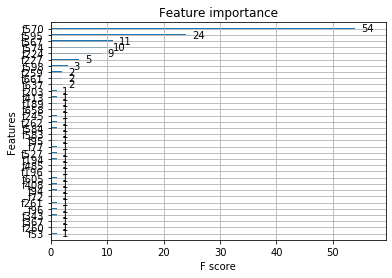

In [12]:
plot_importance(xgb_mod)
plt.show()

672


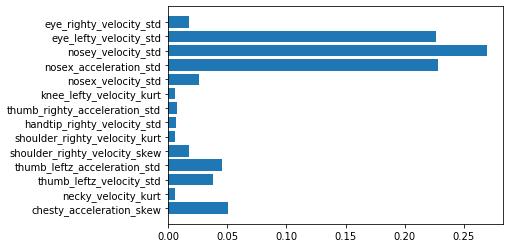

In [43]:
varVal = xgb_mod.feature_importances_.tolist()
varImp = {}
print(len(varVal))
header = list(demo_data.columns) 
for i in range(0,len(varVal)):
    if varVal[i] > .005:
        j = header[i]
        varImp[j]=varVal[i]
list(varImp.keys())
fig = plt.barh(range(len(varImp.keys())), varImp.values(),tick_label=list(varImp.keys()))
plt.show()

## Calculate performance metrics of test data (with optimized cutoff value for classification) 

In [15]:
y_pred = y_prob[:,1]

array([0.9908194 , 0.9906012 , 0.98756427, 0.9738361 , 0.97064555,
       0.97064555, 0.586873  , 0.0037588 , 0.0037588 , 0.03748185,
       0.03748185, 0.03748185, 0.00310924, 0.00173151, 0.00152051,
       0.00170304, 0.00170304, 0.00170304, 0.00161186, 0.00151585,
       0.00151585, 0.00261769, 0.00346779, 0.00346779, 0.00710436,
       0.00754998, 0.9911152 , 0.9911152 , 0.9911152 , 0.9911152 ,
       0.9911152 , 0.9911152 , 0.9911152 , 0.9911152 , 0.9911152 ,
       0.99140245, 0.99140245, 0.99140245, 0.99140245, 0.99140245,
       0.99140245, 0.99140245, 0.99140245, 0.99140245, 0.99140245,
       0.9911152 , 0.9911152 , 0.99140245, 0.99140245, 0.99140245,
       0.9919429 , 0.9919429 , 0.9919429 , 0.9919429 , 0.9919429 ,
       0.9919429 , 0.9919429 , 0.9919429 , 0.9919429 , 0.9919429 ,
       0.9919429 , 0.9919429 , 0.9919429 , 0.9919429 , 0.9919429 ,
       0.9919429 , 0.9919429 , 0.9919429 , 0.99140245, 0.99140245,
       0.9913003 , 0.9912034 , 0.99137676, 0.99137676, 0.99137

In [16]:
for i in range(0,y_pred.size):
    if y_pred[i]>.3:  
        y_pred[i]=1
    else:
        y_pred[i]=0

In [36]:
type(y_pred)

numpy.ndarray

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(133, 72, 16, 231)

In [18]:
confusion_matrix(y_test, y_pred)

array([[133,  72],
       [ 16, 231]])

In [19]:
demo_pred = pd.DataFrame({'pred':y_pred})

,pred
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
447,1.0
448,1.0
449,1.0
450,1.0


In [20]:
confusion_matrix(y_test, demo_pred)

array([[133,  72],
       [ 16, 231]])

## Save Model to pickle

In [22]:
pickle.dump(xgb_mod, open('./final_prediction.pickle', 'wb'))